# Hate Speech Detection


In [1]:
#imports 
import pandas as pd
import numpy as np
import sys
import nltk
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import joblib

###  Loading the data

In [2]:
df = pd.read_csv('labeled_data.csv')

In [3]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [5]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


##### Columns Keys:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users.

0 - hate speech
1 - offensive  language
2 - neither

<Axes: >

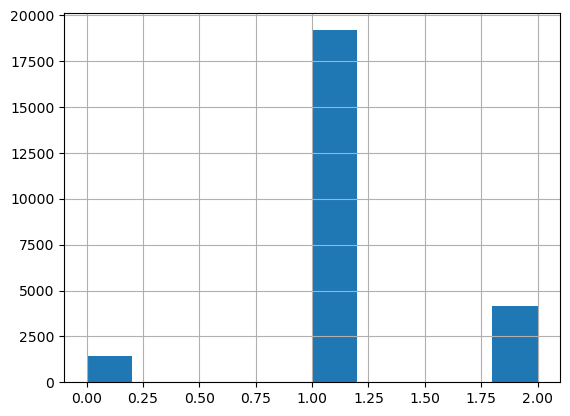

In [6]:
#Distribution of tweets
df['class'].hist()

##### In this problem above we can see a stark class imbalance

In [7]:
tweets = df.tweet

#### Generating Features


In [8]:
stopwords = nltk.corpus.stopwords.words('english')

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern,' ',text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    return parsed_text

In [9]:
preprocess(tweets[0])

"!!! RT MENTIONHERE: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

###### Tokenization

In [10]:
def tokenize(tweet):
    tweet = ' '.join(re.split("[^a-zA-Z]+", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]+", tweet.lower())).strip()
    return tweet.split()



In [11]:
basic_tokenize(preprocess(tweets[0]))

['!!!',
 'rt',
 'mentionhere',
 'as',
 'a',
 'woman',
 'you',
 'shouldn',
 't',
 'complain',
 'about',
 'cleaning',
 'up',
 'your',
 'house.',
 'amp',
 'as',
 'a',
 'man',
 'you',
 'should',
 'always',
 'take',
 'the',
 'trash',
 'out...']

In [12]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.501
)


##### Construct tfidf matrix and get relevant scores

In [13]:
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()}

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


######  Get POS tags for tweets

In [14]:
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)
    

In [15]:
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.501,
    )

###### Construct POS TF matrix and get vocab dict

In [16]:
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i,v in enumerate(pos_vectorizer.get_feature_names_out())}

In [17]:
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    space_pattern = "\s+"
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))


In [18]:
def other_features(tweet):
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    words = preprocess(tweet)
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

In [19]:
def get_feature_array(tweets):
    feats = []
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [20]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [21]:
feats = get_feature_array(tweets)

In [22]:
M = np.concatenate([tfidf,pos,feats],axis=1)

In [23]:
M.shape

(24783, 12295)

In [24]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

##### Running the model

In [25]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [26]:
select = SelectFromModel(LogisticRegression(C=0.01, penalty='l1', solver = 'liblinear'))
X_ = select.fit_transform(X,y)

In [27]:
model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr', dual = 'auto').fit(X_, y)

In [28]:
model = LogisticRegression(solver = 'liblinear',penalty='l2',C=0.01).fit(X_,y)
joblib.dump(model, 'final_model.pkl') 

['final_model.pkl']

In [29]:
y_preds = model.predict(X_)

In [30]:
report = classification_report( y, y_preds )

In [31]:
print(report)


              precision    recall  f1-score   support

           0       0.58      0.18      0.28      1430
           1       0.93      0.96      0.95     19190
           2       0.83      0.93      0.87      4163

    accuracy                           0.91     24783
   macro avg       0.78      0.69      0.70     24783
weighted avg       0.90      0.91      0.90     24783



In [32]:
final_features = select.get_support(indices=True) #get indices of features
final_feature_list = [ u''.__class__(feature_names[i]) for i in final_features]

In [33]:
print(final_feature_list)

['ass', 'beaner', 'bird', 'bitch', 'browni', 'charli', 'color', 'coon', 'cracker', 'cunt', 'da', 'damn', 'dyke', 'fag', 'faggot', 'fuck', 'fuckin', 'gay', 'ghetto', 'girl', 'got', 'gt gt', 'hate', 'ho', 'hoe', 'jihadi', 'kill', 'like', 'lol', 'love', 'mentionher mentionher', 'mock', 'monkey', 'negro', 'nicca', 'nig', 'nigga', 'niggah', 'nigger', 'nigguh', 'oreo', 'pussi', 'queer', 'racist', 'redneck', 'retard', 'shit', 'sole', 'spic', 'stupid', 'trash', 'twat', 'u', 'ugli', 'urlher', 'wetback', 'white', 'white trash', 'ya', 'yanke', 'yellow', 'NN NN NN', 'NNS', 'FKRA', 'FRE', 'num_syllables', 'num_chars', 'num_chars_total', 'num_terms', 'num_words', 'num_unique_words', 'vader compound', 'num_hashtags']


In [34]:
len(final_feature_list)

73

In [35]:
#Getting names for each class of features
ngram_features = final_feature_list[:final_feature_list.index('yellow')+1]
pos_features = final_feature_list[final_feature_list.index('yellow')+1:final_feature_list.index('NNS')+1]
oth_features = final_feature_list[final_feature_list.index('NNS')+1:]

In [36]:
new_vocab = {v:i for i, v in enumerate(ngram_features)}
new_vocab_to_index = {}
for k in ngram_features:
    new_vocab_to_index[k] = vocab[k]

In [37]:
#Get indices of text features
ngram_indices = final_features[:len(ngram_features)]

In [38]:
new_vectorizer = TfidfVectorizer(
    #vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords, #We do better when we keep stopwords
    use_idf=False,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    min_df=1,
    max_df=1.0,
    vocabulary=new_vocab
    )

In [39]:

joblib.dump(new_vectorizer, 'final_tfidf.pkl')

['final_tfidf.pkl']

In [40]:
tfidf_ = new_vectorizer.fit_transform(tweets).toarray()

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [41]:
tfidf_[1,:]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [42]:
tfidf_[1,:].sum()


1.0

In [43]:
X_[1,:tfidf_.shape[1]]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 2.81738461,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [44]:
X_[1,:tfidf_.shape[1]].sum()


2.817384607030878

In [45]:
idf_vals_ = idf_vals[ngram_indices]

In [46]:
idf_vals_.shape

(61,)

In [47]:
joblib.dump(idf_vals_, 'final_idf.pkl') 

['final_idf.pkl']

In [48]:
(tfidf_[1,:]*idf_vals_) == X_[1,:61]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [49]:
tfidf_*idf_vals_ == X_[:,:61]


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [50]:
tfidffinal = tfidf_*idf_vals_

###### POS features

In [51]:
new_pos = {v:i for i, v in enumerate(pos_features)}

In [52]:
#TODO: Pickle pos vectorizer
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
new_pos_vectorizer = TfidfVectorizer(
    #vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None, #We do better when we keep stopwords
    use_idf=False,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    min_df=1,
    max_df=1.0,
    vocabulary=new_pos
    )

In [53]:
joblib.dump(new_pos_vectorizer, 'final_pos.pkl') 

['final_pos.pkl']

In [54]:
pos_ = new_pos_vectorizer.fit_transform(tweet_tags).toarray()

In [55]:
pos_[1,:]

array([1., 1.])

In [56]:
X_[1,61:63]

array([1., 1.])

In [57]:
pos_[:,:] == X_[:,61:63]

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [58]:
pos_[:,:].sum()

23902.0

In [59]:
X_[:,61:63].sum()

23902.0

###### Finally, we can look at the other features

In [60]:
print(other_features_names)

['FKRA', 'FRE', 'num_syllables', 'avg_syl_per_word', 'num_chars', 'num_chars_total', 'num_terms', 'num_words', 'num_unique_words', 'vader neg', 'vader pos', 'vader neu', 'vader compound', 'num_hashtags', 'num_mentions', 'num_urls', 'is_retweet']


In [61]:
print(oth_features)

['FKRA', 'FRE', 'num_syllables', 'num_chars', 'num_chars_total', 'num_terms', 'num_words', 'num_unique_words', 'vader compound', 'num_hashtags']


In [62]:
def other_features_(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    ##SENTIMENT
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words) #count syllables in words
    num_chars = sum(len(w) for w in words) #num chars in words
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet) #Count #, @, and http://
    
    features = [FKRA, FRE, syllables, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['compound'],
                twitter_objs[2],]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array_(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features_(t))
    return np.array(feats)

In [63]:
feats_ = get_feature_array_(tweets)
joblib.dump(new_pos_vectorizer, 'feats_.pkl') 

['feats_.pkl']

In [64]:
feats_[0,:]

array([  8.8   ,  76.56  ,  31.    , 138.    , 140.    ,  25.    ,
        25.    ,  23.    ,   0.4563,   0.    ])

In [65]:
X_[0,63:]

array([  8.8   ,  76.56  ,  31.    , 138.    , 140.    ,  25.    ,
        25.    ,  23.    ,   0.4563,   0.    ])

In [66]:
M_ = np.concatenate([tfidffinal, pos_, feats_],axis=1)

In [67]:
M_.shape


(24783, 73)

In [68]:
X__ = pd.DataFrame(M_)

In [69]:
y_preds_ = model.predict(X__)

In [70]:
report = classification_report( y, y_preds_ )


In [71]:
print(report)

              precision    recall  f1-score   support

           0       0.58      0.18      0.28      1430
           1       0.93      0.96      0.95     19190
           2       0.83      0.93      0.87      4163

    accuracy                           0.91     24783
   macro avg       0.78      0.69      0.70     24783
weighted avg       0.90      0.91      0.90     24783



In [130]:
print('testing starts here-----------')

testing starts here-----------


In [131]:
test_string = 'don\'t play fool with me nigga'
test_vectorizer = joblib.load(open('final_tfidf.pkl','rb'))
test_post_vectorizer = joblib.load(open('final_pos.pkl','rb'))
idf_vals = joblib.load(open('final_idf.pkl','rb'))

In [132]:
test_tfidf_ = test_vectorizer.fit_transform([test_string]).toarray()

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [133]:
len(test_tfidf_)

1

In [134]:
vocab = {v:i for i, v in enumerate(test_vectorizer.get_feature_names_out())}
idf_dict = {i:idf_vals[i] for i in vocab.values()}

In [135]:
tweet_tags = []
#tokens = basic_tokenize(preprocess(t))
tokens = joblib.load(open('final_tokens.pkl','rb'))
#joblib.dump(tokens, 'final_tokens.pkl')
tags = nltk.pos_tag(tokens)
tag_list = [x[1] for x in tags]
#for i in range(0, len(tokens)):
tag_str = " ".join(tag_list)
tweet_tags.append(tag_str)

In [136]:
pos_ = test_post_vectorizer.fit_transform(tweet_tags).toarray()
len(pos_)

1

In [137]:
feats_ = get_feature_array_([test_string])
len(feats_)

1

In [138]:
fin = np.concatenate([test_tfidf_, pos_, feats_],axis=1)

In [139]:
pred = model.predict(fin)

In [140]:
print(f"Prediction for fin: {pred}")  # Output: array([2])
print(f"Class label: {'neither' if pred[0] == 2 else 'hate speech' if pred[0] == 0 else 'offensive language'}")

Prediction for fin: [1]
Class label: offensive language


In [141]:
pip list

Package                       Version
----------------------------- ---------------
aiobotocore                   2.4.2
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-catalogs             0.2.0
anaconda-client               1.12.0
anaconda-navigator            2.4.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.2.1
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcal

In [142]:
nm = joblib.load(open('final_model.pkl','rb'))
nm.predict(fin)

array([1])